## Testing out some code to hit the NHL API :)


Resources

* https://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d
* https://nhl-api-explorer.herokuapp.com/
* https://gitlab.com/dword4/nhlapi
* https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md#game-ids
* https://github.com/dword4/nhlapi

Game IDs
* The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). 
* The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 03 = playoffs, 04 = all-star. 
* The final 4 digits identify the specific game number. 
* For regular season and preseason games, this ranges from 0001 to the number of games played. (1271 for seasons with 31 teams (2017 and onwards) and 1230 for seasons with 30 teams). 
* For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

In [5]:
# Standard library modules
import datetime
import glob
import json
import math
import os
import shutil
import sys
import time
from enum import Enum

# Third-party libraries
import jsonlines
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import RegularPolygon
from PIL import Image

color_map = plt.cm.winter

### Getting data from the NHL API
- Due to the memory-intensive files, each file has been capped to ~50mb
- Files will share a common prefix followed by an incremental suffix
- The API calls will be looped over the year(s), season type(s) specified, starting from game "0001" up to a specified maximum

In [31]:
class SeasonType(Enum):
    PRE_SEASON = "01"
    REGULAR_SEASON = "02"
    PLAYOFFS = "03"
    ALL_STAR = "04"

class FileHandler:
    """Class to handle writing JSON data to file(s) based on a maximum file size."""    
    
    def __init__(self, max_file_size_bytes, output_folder):
        """Initialize the file handler."""
        self.max_file_size_bytes = max_file_size_bytes
        self.output_folder = output_folder
        self.current_file_size = 0
        self.current_file_index = 1
        self.output_file = self._create_output_file()

    def _create_output_file(self):
        """Summary: Create a new output file.

        Returns:
            str: The full path to the output file.
        """
        output_file = os.path.join(self.output_folder, f'livefeed_{self.current_file_index}.jsonl')
        with open(output_file, 'w') as file:
            pass  # Create an empty file
        return output_file

    def write_to_file(self, json_data):
        """Write the JSON data to file.
        
        Args:
            json_data (dict): The JSON data to write to file.
            
        Returns:
            None
        """
        json_data_str = json.dumps(json_data)
        json_size = len(json_data_str.encode('utf-8'))

        # Check if writing the JSON data would exceed the max file size
        if self.current_file_size + json_size > self.max_file_size_bytes:
            self.current_file_index += 1
            self.current_file_size = 0
            self.output_file = self._create_output_file()
        with open(self.output_file, 'a') as file:
            file.write(json_data_str + '\n')
        
        self.current_file_size += json_size

def call_endpoint(year, season_type, game_id):
    url = f"http://statsapi.web.nhl.com/api/v1/game/{year}{season_type}{game_id}/feed/live"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Error calling {url}: {e}")
    except Exception as e:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - An unexpected error occurred: {e}")

def get_data(season = '2022'):
    # Specify the years and season types to get data for
    years = [f'{season}']  # Add more years as needed
    season_types = [SeasonType.REGULAR_SEASON]

    # Generate game IDs from "0001" to "1313"
    game_ids = [str(i).zfill(4) for i in range(1, 1314)] # TODO: Change this to 1314

    # Specify the maximum file size (in bytes) before splitting
    max_file_size_bytes = 50 * 1024 * 1024  # 50MB

    # Specify where output files are written to
    output_folder = f'.output/{season}'

    # Check if the folder already exists, and if so, remove it
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    # Create the folder
    os.makedirs(output_folder, exist_ok=True)

    # Initialize the file handler
    file_handler = FileHandler(max_file_size_bytes, output_folder)

    # Initialize a timer
    start_time = time.time()
    interval = 10

    # For each year, season type, and game ID, call the API and write the data to file
    for year in years:
        for season_type in season_types:
            print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Getting data for {year} {season_type.name}")
            for game_id in game_ids:
                
                # Print the current game ID every 10 seconds for progress tracking
                current_time = time.time()
                if current_time - start_time >= interval:
                    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Current game_id: {game_id}")
                    start_time = current_time

                # Call the API
                res = call_endpoint(year, season_type.value, game_id)
                    
                if res is None:
                    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Reached the end of possible game data for {year} {season_type.name}.")
                    break
                
                if res is not None:
                    del res['gameData']
                    del res['liveData']['linescore']
                    del res['liveData']['boxscore']
                    del res['liveData']['decisions']
                    file_handler.write_to_file(res)


In [33]:
get_data(season = '2021')
get_data(season = '2022')

2023-09-08 20:51:50 - Getting data for 2021 REGULAR_SEASON
2023-09-08 20:52:00 - Current game_id: 0065
2023-09-08 20:52:10 - Current game_id: 0133
2023-09-08 20:52:20 - Current game_id: 0201
2023-09-08 20:52:30 - Current game_id: 0268
2023-09-08 20:52:40 - Current game_id: 0336
2023-09-08 20:52:50 - Current game_id: 0406
2023-09-08 20:53:01 - Current game_id: 0475
2023-09-08 20:53:11 - Current game_id: 0540
2023-09-08 20:53:21 - Current game_id: 0606
2023-09-08 20:53:31 - Current game_id: 0668
2023-09-08 20:53:41 - Current game_id: 0733
2023-09-08 20:53:51 - Current game_id: 0798
2023-09-08 20:54:01 - Current game_id: 0862
2023-09-08 20:54:11 - Current game_id: 0928
2023-09-08 20:54:21 - Current game_id: 0993
2023-09-08 20:54:31 - Current game_id: 1059
2023-09-08 20:54:41 - Current game_id: 1125
2023-09-08 20:54:51 - Current game_id: 1190
2023-09-08 20:55:01 - Current game_id: 1258
2023-09-08 20:55:10 - Error calling http://statsapi.web.nhl.com/api/v1/game/2021021313/feed/live: 404 Cli

In [176]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
def get_shot_goal_data(player_names=[], season = 2022):

    # Match files with glob pattern
    pattern = os.path.join(f'.output/{season}', 'livefeed_*.jsonl')
    matching_files = glob.glob(pattern)
    
    # Set the event types of interest
    event_types = ['Shot','Goal']

    # Coordinates D1
    play_coordinates = {}
    play_coordinates['Shot'] = {}
    play_coordinates['Shot']['x'] = []
    play_coordinates['Shot']['y'] = []
    play_coordinates['Goal'] = {}
    play_coordinates['Goal']['x'] = []
    play_coordinates['Goal']['y'] = []

    # Coordinates D2
    play_coordinates_for_dataframe = {
        "game_id": [],
        "play_id": [],
        "x_coord":[], 
        "y_coord":[], 
        "event":[],
        "event_type":[],
        "event_desc": [],
        "period": [],
        "period_time": [],
        "player_name": [],
        "player_id": [],
        "player_type": []
        }

    # For each matching file
    for file_path in matching_files:

        # Open the file
        with jsonlines.open(file_path, 'r') as file:

            # Each line in the file represents a single game
            for jsonline in file:

                # Skip if no live data for current game
                if 'liveData' not in jsonline.keys():
                    continue

                # Get the plays from each game
                plays = jsonline['liveData']['plays']['allPlays']
                game_id = jsonline['gamePk']

                # Loop over each play in the current game
                for play in plays:
                    
                    # Look for players in the play
                    if 'players' in play:

                        for player in play['players']:
                        
                            if len(player_names) > 0:
                                
                                # If player names are specified, skip any plays that don't involve those players
                                if not any(player_name in player['player']['fullName'] for player_name in player_names):
                                    continue

                            if player['playerType'] in ['Shooter', 'Scorer']:
                                player_type = player['playerType']
                                player_id = player['player']['id']
                                player_name = player['player']['fullName']

                                for event in event_types:
                                    # Look for Shot and Goal events that have coordinates
                                    if play['result']['event'] in event and play['coordinates']:
                                        # Save the coordinates to d1
                                        play_coordinates[event]['x'].append(play['coordinates']['x'])
                                        play_coordinates[event]['y'].append(play['coordinates']['y'])
                                        # Save the coordinates to d2
                                        play_coordinates_for_dataframe["game_id"].append(game_id)
                                        play_coordinates_for_dataframe["x_coord"].append(play['coordinates']['x'])
                                        play_coordinates_for_dataframe["y_coord"].append(play['coordinates']['y'])
                                        play_coordinates_for_dataframe["event"].append(play['result']['event'])
                                        play_coordinates_for_dataframe["event_type"].append(play['result'].get('secondaryType', None))
                                        play_coordinates_for_dataframe["event_desc"].append(play['result']['description'])
                                        play_coordinates_for_dataframe["period"].append(play['about']['period'])
                                        play_coordinates_for_dataframe["period_time"].append(play['about']['periodTime'])
                                        play_coordinates_for_dataframe["play_id"].append(play['about']['eventIdx'])
                                        play_coordinates_for_dataframe["player_name"].append(player_name)
                                        play_coordinates_for_dataframe["player_id"].append(player_id)
                                        play_coordinates_for_dataframe["player_type"].append(player_type)

    # Convert to pandas dataframe
    play_coordinates_df = pd.DataFrame.from_dict(play_coordinates_for_dataframe)

    # Drop dups
    play_coordinates_dedupe_df = play_coordinates_df.drop_duplicates()

    # Add some features
    play_coordinates_dedupe_df['goal'] = np.where(play_coordinates_dedupe_df['event']== 'Goal', 1, 0)
    play_coordinates_dedupe_df['league'] = 'NHL'

    # See data
    return play_coordinates, play_coordinates_dedupe_df

# League data, pass player_names as an empty list
league_coordinates, league_coordinates_df = get_shot_goal_data(player_names=[], season = 2022)

# Play data, specify player_names
player_coordinates, player_coordinates_df = get_shot_goal_data(player_names=['Connor McDavid', 'Auston Matthews', 'Alex Ovechkin', 'Sidney Crosby', 'Jack Eichel'], season = 2022)

player_coordinates_df.head(5)

,game_id,play_id,x_coord,y_coord,event,event_type,event_desc,period,period_time,player_name,player_id,player_type,goal,league
0,2022020004,91,69.0,-13.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,1,15:27,Jack Eichel,8478403,Shooter,0,NHL
1,2022020004,94,70.0,9.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,1,15:57,Jack Eichel,8478403,Shooter,0,NHL
2,2022020004,96,49.0,-20.0,Shot,Wrist Shot,Jack Eichel Wrist Shot saved by Jonathan Quick,1,16:08,Jack Eichel,8478403,Shooter,0,NHL
3,2022020004,136,-64.0,-17.0,Shot,Wrist Shot,Jack Eichel Wrist Shot saved by Jonathan Quick,2,02:59,Jack Eichel,8478403,Shooter,0,NHL
4,2022020004,139,-53.0,-21.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,2,03:19,Jack Eichel,8478403,Shooter,0,NHL


### Getting player headshots

In [771]:
import requests
import pandas as pd
from io import BytesIO
from PIL import Image
from IPython.display import display

# Function to get player headshot parsed into a dataframe
def get_player_headshots(url_base, player_id_list, show_head = False):

    # List of player IDs
    player_ids = player_id_list

    # Initialize an empty DataFrame
    data = {'player_id': [], 'img': []}
    df = pd.DataFrame(data)

    # URL template for player images
    url_template = url_base

    # Loop through player IDs and fetch images
    for player_id in player_ids:
        # Construct the URL for the current player ID
        image_url = url_template.format(player_id=player_id)
        
        # Send an HTTP GET request to fetch the image data
        response = requests.get(image_url)
        
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Read the image data into a BytesIO object
            image_data = BytesIO(response.content)
            
            # Open the image using PIL
            img = Image.open(image_data)
            
            # Append the player ID and image data to the DataFrame
            df = df.append({'player_id': player_id, 'img': img}, ignore_index=True)
        else:
            print(f"Failed to fetch the image for Player ID {player_id}. Status code: {response.status_code}")
   
        if show_head == True:
            print(df.head(10))

    return df

# Function to debug and show a player headshot given a parsed dataframe
def show_player_headshot(index_to_display, data, image_col_name='img', player_id_col_name='player_id'):

    # Choose an index from the DataFrame (e.g., 0 for the first image)
    index_to_display = index_to_display

    # Get the image and player ID from the DataFrame
    image_to_display = data.at[index_to_display, f'{image_col_name}']
    player_id = data.at[index_to_display, f'{player_id_col_name}']

    # Display the image
    display(image_to_display)

    # Optionally, you can also print the player ID
    return print(f"Player ID: {player_id}")

# Setup vars
#player_list = [8477934, 8480833, 8480835]
#url_base = "https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg"

# Run function 1
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(league_coordinates_df[['player_id']]))

# Run function 2
show_player_headshot(0, headshots_df, 'img', 'player_id')

KeyboardInterrupt: 

In [177]:
# Enhance league & shot dataframes to have headshots stored in column = img
league_coordinates_df = league_coordinates_df.merge(headshots_df, how = 'left', left_on ='player_id', right_on= 'player_id')
player_coordinates_df = player_coordinates_df.merge(headshots_df, how = 'left', left_on ='player_id', right_on= 'player_id')

player_coordinates_df.head(5)

,game_id,play_id,x_coord,y_coord,event,event_type,event_desc,period,period_time,player_name,player_id,player_type,goal,league,img
0,2022020004,91,69.0,-13.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,1,15:27,Jack Eichel,8478403,Shooter,0,NHL,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,2022020004,94,70.0,9.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,1,15:57,Jack Eichel,8478403,Shooter,0,NHL,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,2022020004,96,49.0,-20.0,Shot,Wrist Shot,Jack Eichel Wrist Shot saved by Jonathan Quick,1,16:08,Jack Eichel,8478403,Shooter,0,NHL,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,2022020004,136,-64.0,-17.0,Shot,Wrist Shot,Jack Eichel Wrist Shot saved by Jonathan Quick,2,02:59,Jack Eichel,8478403,Shooter,0,NHL,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,2022020004,139,-53.0,-21.0,Shot,Snap Shot,Jack Eichel Snap Shot saved by Jonathan Quick,2,03:19,Jack Eichel,8478403,Shooter,0,NHL,<PIL.JpegImagePlugin.JpegImageFile image mode=...


## Analyzing shots & goals

<ipython-input-182-50f426f252cb>:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  player_shots.columns = ["_".join(x) for x in player_shots.columns.ravel()]
<ipython-input-182-50f426f252cb>:10: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  league_shots.columns = ["_".join(x) for x in league_shots.columns.ravel()]


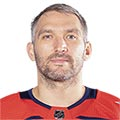

Player ID: 8471214.0


,player_name,player_id,league,games_played,sog_player,goals_player,conversion_player,sog_league,goals_league,conversion_league,conv_spread,img
2,Connor McDavid,8478402,NHL,81,355,65,0.1831,82538,8474,0.1027,0.0804,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,Auston Matthews,8479318,NHL,73,329,42,0.1277,82538,8474,0.1027,0.0250,<PIL.JpegImagePlugin.JpegImageFile image mode=...
0,Alex Ovechkin,8471214,NHL,73,296,42,0.1419,82538,8474,0.1027,0.0392,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,Sidney Crosby,8471675,NHL,77,257,34,0.1323,82538,8474,0.1027,0.0296,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,Jack Eichel,8478403,NHL,63,227,28,0.1233,82538,8474,0.1027,0.0206,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [182]:
# Get player summaries
player_shots = player_coordinates_df.groupby(['player_name', 'player_id', 'league']).agg({'game_id':['nunique'], 'goal':['count', 'sum']})
player_shots.columns = ["_".join(x) for x in player_shots.columns.ravel()]
player_shots = player_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals", "game_id_nunique": "games_played"})
player_shots = player_shots.reset_index()
player_shots['conversion'] = round(player_shots['goals'] / player_shots['sog'], 4)

# Get league summaries
league_shots = league_coordinates_df.groupby('league').agg({'goal':['count', 'sum']})
league_shots.columns = ["_".join(x) for x in league_shots.columns.ravel()]
league_shots = league_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals"})
league_shots = league_shots.reset_index()
league_shots['conversion'] = round(league_shots['goals'] / league_shots['sog'], 4)

# Join player summaries with league summaries
df3 = player_shots.merge(league_shots, on = "league", suffixes = ("_player", "_league"))
df3["conv_spread"] = df3["conversion_player"] - df3["conversion_league"]

# Join player headshots bacl om
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(df3[['player_id']]))
show_player_headshot(0, headshots_df, 'img', 'player_id')
df4 = df3.merge(headshots_df, how = 'left', left_on ='player_id', right_on= 'player_id')

# Cleanup data
df4.sort_values(by = "sog_player", ascending = False).head(10)

## Shot location analysis
* Using bigquery data dump

Credit: [The Commute Sports](https://thecommutesports.com/2022/08/06/creating-nhl-shot-maps-with-python/)

What we are going to do first is set up a binning grid. I want to understand where shots are taken on the ice, but I do not want to see all individual shots. By taking spatial average we can make a more insightful and visual representation. The position data from the API extends from:

* X: -100 to 100 (meters)
* Y: -42.5 to 42.5 (meters)


For our binning we are using hex plots from matplotlib to extract the raw binning data and will use drawn rectangles (again matplotlib) for the final visuals.
To start we define our figure dimensions and grid size:

Next we will find the efficiency of the league at each location on the ice. To do this we call the hexbin method and extract the location vertex and count data.

**Once thing to note is that since the scorer never scores on their own net we must make sure the negative locations are flipped to always represent the attacking side.**

This is all because every period the player switch sides and the coordinate system is fixed.

In [381]:
# Read in xg test dump from bigquery
data1 = pd.read_csv('.bq_xg/202202_test.csv', delimiter= ',')

# Enhance league & shot dataframes to have headshots stored in column = img
data2 = data1.merge(headshots_df, how = 'left', left_on ='player_id', right_on= 'player_id')

# Preview
print(f'Rows: {len(data2)}')
data2.head(5)

Rows: 110967


,play_id,game_id,event_id,team_id,player_id,player_name,event_type,event_description,play_period,play_total_seconds_elapsed,...,rink_side,zone_type,zone,game_state,game_state_skaters,xg_strength_state_code,xg_model_id,xg_proba,x_goal,img
0,d4caae9ac74a5dce2be249cb091cd574,2022020288,23,28,8477034,Jaycob Megna,MISSED_SHOT,Jaycob Megna Wide of Net Igor Shesterkin,1,454,...,right,offensive_zone,c_point,5v5,even strength,ev,XGB_target_20222023_training_2017-to-2021,0.001601,0,NaN
1,6d0a0aebe279b34303d76d5f724170d8,2022020397,152,4,8475763,Kevin Hayes,SHOT,Kevin Hayes Wrist Shot saved by Alexandar Geor...,1,35,...,left,offensive_zone,c_point,5v5,even strength,ev,XGB_target_20222023_training_2017-to-2021,0.028712,0,NaN
2,b1f411f287a9f7a9a6c4194beabb2af6,2022020659,436,15,8475149,Marcus Johansson,GOAL,"Marcus Johansson (11) Wrist Shot, assists: none",3,2958,...,right,offensive_zone,c_point,5v5,even strength,ev,XGB_target_20222023_training_2017-to-2021,0.054401,1,NaN
3,ccb604a7c0ddf7f753eeeaa69d3e4cf2,2022020842,515,53,8479976,Juuso Valimaki,MISSED_SHOT,Juuso Valimaki Wide of Net Jordan Binnington,2,2186,...,center,offensive_zone,c_point,4v5,skater advantage,pp,XGB_target_20222023_training_2017-to-2021,0.002374,0,NaN
4,cb7f503ca629f850f8dec424a81716a8,2022020059,451,6,8478415,Jakub Zboril,SHOT,Jakub Zboril Wrist Shot saved by John Gibson,1,559,...,left,offensive_zone,c_point,5v5,even strength,ev,XGB_target_20222023_training_2017-to-2021,0.046771,0,NaN


In [774]:
# Subset
data3 = data2[['player_name', 'player_id', 'img', 'event_type', 'play_period', 'zone_type', 'zone', 'xg_strength_state_code', 'x_goal', 'xg_proba', 'play_distance', 'play_angle', 'x_coord', 'y_coord']]

# Normalize x & y coordinates such that when x is negative, flip x and y to force to be shooting "right"
data3['adj_x_coord'] = data3.apply(lambda row: -(row['x_coord']) if row['x_coord'] < 0 else row['x_coord'], axis=1)
data3['adj_y_coord'] = data3.apply(lambda row: -(row['y_coord']) if row['x_coord'] < 0 else row['y_coord'], axis=1)

# Print summary stats
print("xGoals Max {:.2f}".format(data3['xg_proba'].max()))
print("xGoals Mean {:.2f}".format(data3['xg_proba'].mean()))
print("X Cords: {}, {}".format(data3['x_coord'].min(),data3['adj_x_coord'].max()))
print("Y Cords: {}, {}".format(data3['y_coord'].min(),data3['adj_y_coord'].max()))

# Preview data
data3.head(5)

<ipython-input-774-e49ff964cd7d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



xGoals Max 0.77
xGoals Mean 0.07
X Cords: -99.0, 99.0
Y Cords: -42.0, 42.0


<ipython-input-774-e49ff964cd7d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,player_name,player_id,img,event_type,play_period,zone_type,zone,xg_strength_state_code,x_goal,xg_proba,play_distance,play_angle,x_coord,y_coord,adj_x_coord,adj_y_coord
0,Jaycob Megna,8477034,NaN,MISSED_SHOT,1,offensive_zone,c_point,ev,0,0.001601,45.10,3.81,44.0,3.0,44.0,3.0
1,Kevin Hayes,8475763,NaN,SHOT,1,offensive_zone,c_point,ev,0,0.028712,50.01,-1.15,-39.0,1.0,39.0,-1.0
2,Marcus Johansson,8475149,NaN,GOAL,3,offensive_zone,c_point,ev,1,0.054401,37.22,6.17,52.0,4.0,52.0,4.0
3,Juuso Valimaki,8479976,NaN,MISSED_SHOT,2,offensive_zone,c_point,pp,0,0.002374,56.00,0.00,33.0,0.0,33.0,0.0
4,Jakub Zboril,8478415,NaN,SHOT,1,offensive_zone,c_point,ev,0,0.046771,41.30,-6.95,48.0,-5.0,48.0,-5.0


In [766]:
data3[data3['player_name'] == 'Roman Josi']


,player_name,img,event_type,play_period,zone_type,zone,xg_strength_state_code,x_goal,xg_proba,play_distance,play_angle,x_coord,y_coord,adj_x_coord,adj_y_coord
46,Roman Josi,NaN,SHOT,2,offensive_zone,c_point,pp,0,0.103748,38.01,-1.51,51.0,-1.0,51.0,-1.0
54,Roman Josi,NaN,SHOT,2,offensive_zone,c_point,ev,0,0.030662,56.14,-4.09,-33.0,4.0,33.0,-4.0
469,Roman Josi,NaN,SHOT,2,offensive_zone,c_point,ev,0,0.069460,45.00,0.00,-44.0,0.0,44.0,-0.0
544,Roman Josi,NaN,SHOT,1,offensive_zone,c_point,pp,0,0.070147,52.35,-6.58,37.0,-6.0,37.0,-6.0
779,Roman Josi,NaN,SHOT,2,offensive_zone,c_point,ev,0,0.046810,53.01,-1.08,-36.0,1.0,36.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108274,Roman Josi,NaN,SHOT,3,neutral_zone,neutral_zone,ev,0,0.003621,76.06,24.88,-20.0,-32.0,20.0,32.0
108735,Roman Josi,NaN,SHOT,3,neutral_zone,neutral_zone,ev,0,0.001995,85.62,22.67,-10.0,-33.0,10.0,33.0
108987,Roman Josi,NaN,SHOT,1,neutral_zone,neutral_zone,ev,0,0.003697,64.63,8.00,25.0,9.0,25.0,9.0
109999,Roman Josi,NaN,SHOT,1,defensive_zone,defensive_zone,ev,0,0.009724,172.05,6.34,-82.0,19.0,82.0,-19.0


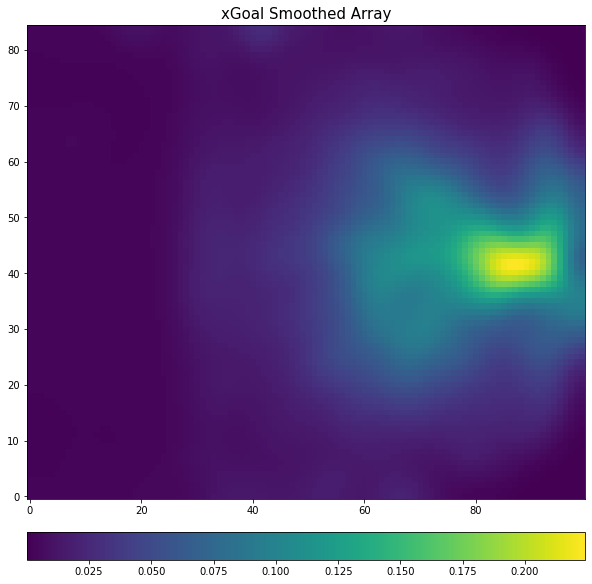

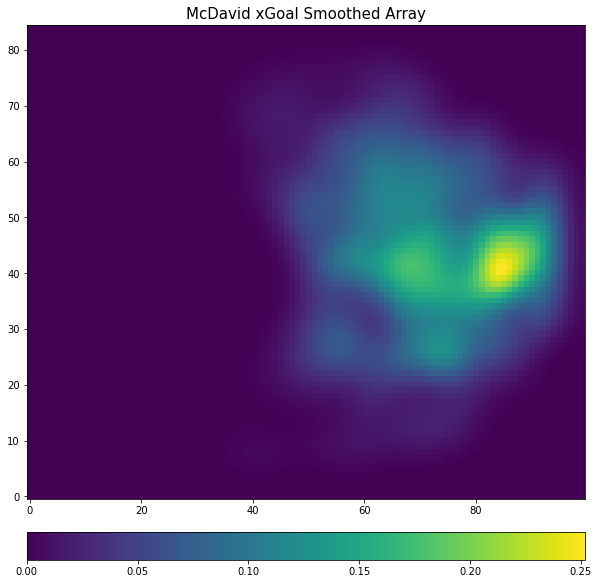

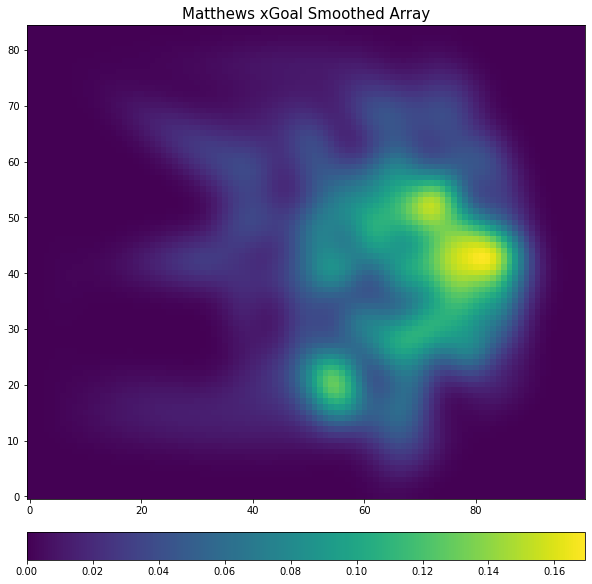

In [775]:
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter 
import matplotlib.pyplot as plt

ev_data = data3[data3['xg_strength_state_code'] == 'ev']

# Plot xg_proba 
def create_xg_array(data, is_smooth = True):
    [x,y] = np.round(np.meshgrid(np.linspace(0,100,100), np.linspace(-42.5, 42.5, 85)))
    xgoals = griddata(
                (data['adj_x_coord'], data['adj_y_coord']),
                data['xg_proba'],
                (x, y),
                method = 'cubic',
                fill_value = 0)
    xgoals = np.where(xgoals < 0, 0, xgoals)

    if is_smooth:
        xgoals = gaussian_filter(xgoals, sigma = 3)

    return xgoals

all_xg = create_xg_array(ev_data, is_smooth = True)
mcdavid_xg = create_xg_array(ev_data[ev_data['player_name'] == 'Connor McDavid'], is_smooth = True)
matthews_xg = create_xg_array(ev_data[ev_data['player_name'] == 'Auston Matthews'], is_smooth = True)

# Smoothen it out
fig = plt.figure(figsize=(10,12), facecolor='w', edgecolor='k')
plt.imshow(all_xg, origin = 'lower')
plt.colorbar(orientation = 'horizontal', pad = 0.05)
plt.title('xGoal Smoothed Array',fontdict={'fontsize': 15})
plt.show()

fig = plt.figure(figsize=(10,12), facecolor='w', edgecolor='k')
plt.imshow(mcdavid_xg, origin = 'lower')
plt.colorbar(orientation = 'horizontal', pad = 0.05)
plt.title('McDavid xGoal Smoothed Array',fontdict={'fontsize': 15})
plt.show()

fig = plt.figure(figsize=(10,12), facecolor='w', edgecolor='k')
plt.imshow(matthews_xg, origin = 'lower')
plt.colorbar(orientation = 'horizontal', pad = 0.05)
plt.title('Matthews xGoal Smoothed Array',fontdict={'fontsize': 15})
plt.show()

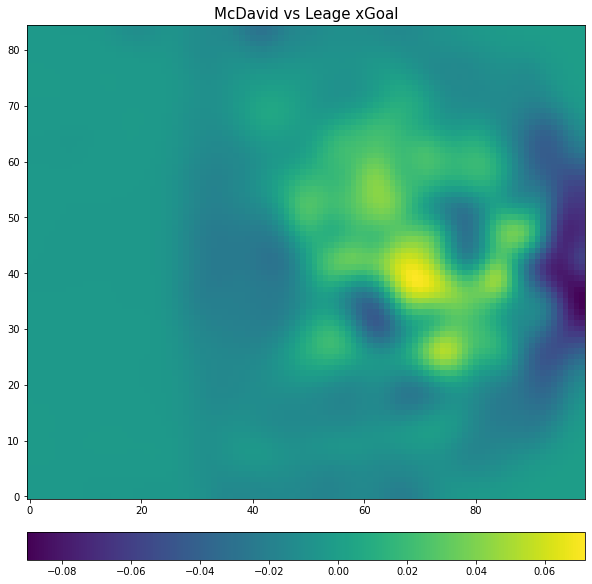

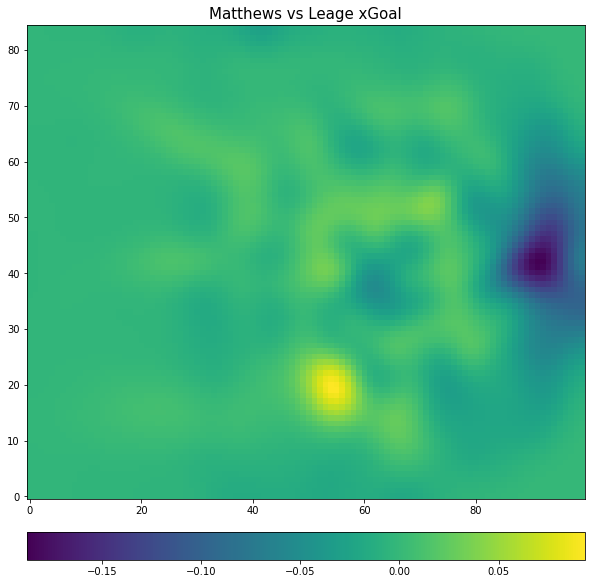

In [776]:
difference1 = mcdavid_xg - all_xg
difference2 = matthews_xg - all_xg

fig = plt.figure(figsize=(10,12), facecolor='w', edgecolor='k')
plt.imshow(difference1, origin = 'lower')
plt.colorbar(orientation = 'horizontal', pad = 0.05)
plt.title('McDavid' + ' vs Leage xGoal',fontdict={'fontsize': 15})
plt.show()

fig = plt.figure(figsize=(10,12), facecolor='w', edgecolor='k')
plt.imshow(difference2, origin = 'lower')
plt.colorbar(orientation = 'horizontal', pad = 0.05)
plt.title('Matthews' + ' vs Leage xGoal',fontdict={'fontsize': 15})
plt.show()

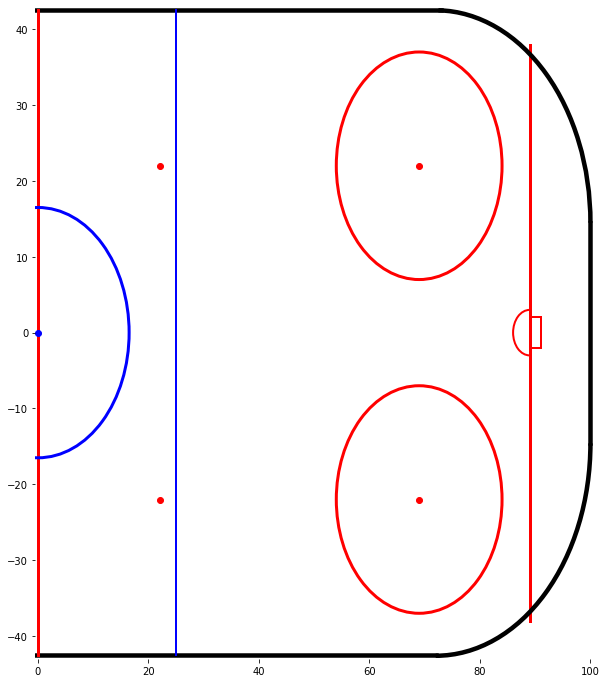

In [777]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def create_rink(
    ax, 
    plot_half = False, 
    board_radius = 28,
    alpha = 1,
):
    #Cornor Boards
    ax.add_artist(mpl.patches.Arc((100-board_radius , (85/2)-board_radius), board_radius * 2, board_radius * 2 , theta1=0, theta2=89, edgecolor='Black', lw=4.5,zorder=0, alpha = alpha)) #Top Right
    ax.add_artist(mpl.patches.Arc((-100+board_radius+.1 , (85/2)-board_radius), board_radius * 2, board_radius * 2 ,theta1=90, theta2=180, edgecolor='Black', lw=4.5,zorder=0, alpha = alpha)) #Top Left
    ax.add_artist(mpl.patches.Arc((-100+board_radius+.1 , -(85/2)+board_radius-.1), board_radius * 2, board_radius * 2 ,theta1=180, theta2=270, edgecolor='Black', lw=4.5,zorder=0, alpha = alpha)) #Bottom Left
    ax.add_artist(mpl.patches.Arc((100-board_radius , -(85/2)+board_radius-.1), board_radius * 2, board_radius * 2 ,theta1=270, theta2=360, edgecolor='Black', lw=4.5,zorder=0, alpha = alpha)) #Bottom Right

    #[x1,x2],[y1,y2]
    #Plot Boards 
    ax.plot([-100+board_radius,100-board_radius], [-42.5, -42.5], linewidth=4.5, color="Black",zorder=0, alpha = alpha) #Bottom
    ax.plot([-100+board_radius-1,100-board_radius+1], [42.5, 42.5], linewidth=4.5, color="Black",zorder=0, alpha = alpha) #Top
    ax.plot([-100,-100], [-42.5+board_radius, 42.5-board_radius], linewidth=4.5, color="Black",zorder=0, alpha = alpha) #Left
    ax.plot([100,100], [-42.5+board_radius, 42.5-board_radius], linewidth=4.5, color="Black",zorder=0, alpha = alpha) #Right

    #Goal Lines 
    adj_top = 4.6
    adj_bottom = 4.5
    ax.plot([89,89], [-42.5+adj_bottom, 42.5 - adj_top], linewidth=3, color="Red",zorder=0, alpha = alpha)
    ax.plot([-89,-89], [-42.5+adj_bottom, 42.5 - adj_top], linewidth=3, color="Red",zorder=0, alpha = alpha)

    #Plot Center Line
    ax.plot([0,0], [-42.5, 42.5], linewidth=3, color="Red",zorder=0, alpha = alpha)
    ax.plot(0,0, markersize = 6, color="Blue", marker = "o",zorder=0, alpha = alpha) #Center FaceOff Dots
    ax.add_artist(mpl.patches.Circle((0, 0), radius = 33/2, facecolor='none', edgecolor="Blue", linewidth=3,zorder=0, alpha = alpha)) #Center Circle

    #Zone Faceoff Dots
    ax.plot(69,22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(69,-22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(-69,22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(-69,-22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)

    #Zone Faceoff Circles
    ax.add_artist(mpl.patches.Circle((69, 22), radius = 15, facecolor='none', edgecolor="Red", linewidth=3,zorder=0, alpha = alpha)) 
    ax.add_artist(mpl.patches.Circle((69,-22), radius = 15, facecolor='none', edgecolor="Red", linewidth=3,zorder=0, alpha = alpha)) 
    ax.add_artist(mpl.patches.Circle((-69,22), radius = 15, facecolor='none', edgecolor="Red", linewidth=3,zorder=0, alpha = alpha)) 
    ax.add_artist(mpl.patches.Circle((-69,-22), radius = 15, facecolor='none', edgecolor="Red", linewidth=3,zorder=0, alpha = alpha)) 

    #Neutral Zone Faceoff Dots
    ax.plot(22,22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(22,-22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(-22,22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)
    ax.plot(-22,-22, markersize = 6, color="Red", marker = "o",zorder=0, alpha = alpha)

    #Plot Blue Lines
    ax.plot([25,25], [-42.5, 42.5], linewidth=2, color="Blue",zorder=0, alpha = alpha)
    ax.plot([-25,-25], [-42.5, 42.5], linewidth=2, color="Blue",zorder=0, alpha = alpha)

    #Goalie Crease
    ax.add_artist(mpl.patches.Arc((89, 0), 6,6,theta1=90, theta2=270,  facecolor="Blue", edgecolor='Red', lw=2,zorder=0, alpha = alpha))
    ax.add_artist(mpl.patches.Arc((-89, 0), 6,6, theta1=270, theta2=90, facecolor="Blue", edgecolor='Red', lw=2,zorder=0, alpha = alpha))

    #Goal
    ax.add_artist(mpl.patches.Rectangle((89, 0 - (4/2)), 2, 4, lw=2, color='Red',fill=False,zorder=0, alpha = alpha))
    ax.add_artist(mpl.patches.Rectangle((-89 - 2, 0 - (4/2)), 2, 4, lw=2, color='Red',fill=False,zorder=0, alpha = alpha))

    if plot_half == False:
        # Set axis limits
        ax.set_xlim(-101, 101)
        ax.set_ylim(-43, 43)  

    elif plot_half == True:
        # Set axis limits
        ax.set_xlim(-0.5, 100.5)
        ax.set_ylim(-43, 43) 


    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(10,12), facecolor='w', edgecolor='k')
create_rink(ax, plot_half=True)
plt.show()

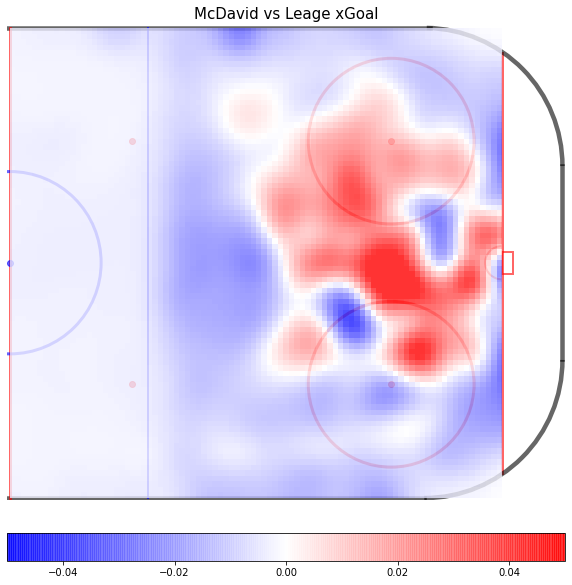

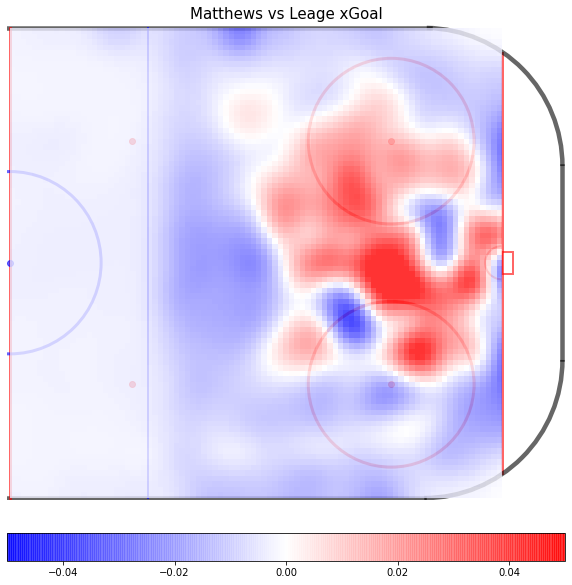

In [778]:
import matplotlib as mpl
difference1 = difference1[:,:90]
difference2: difference2[:,90]

fig, ax = plt.subplots(1,1, figsize=(10,12), facecolor='w', edgecolor='k')
create_rink(ax, plot_half=True, board_radius= 25, alpha = .6)
ax = ax.imshow(difference1, extent=(0, 89, -42.5, 42.5), cmap='bwr', origin='lower', norm=mpl.colors.Normalize(vmin=-0.05, vmax=0.05), alpha=0.8)  # Adjust alpha for heatmap
fig.colorbar(ax, orientation="horizontal",pad = 0.05)
plt.title('McDavid' + ' vs Leage xGoal',fontdict={'fontsize': 15})
plt.axis('off')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,12), facecolor='w', edgecolor='k')
create_rink(ax, plot_half=True, board_radius= 25, alpha = .6)
ax = ax.imshow(difference1, extent=(0, 89, -42.5, 42.5), cmap='bwr', origin='lower', norm=mpl.colors.Normalize(vmin=-0.05, vmax=0.05), alpha=0.8)  # Adjust alpha for heatmap
fig.colorbar(ax, orientation="horizontal", pad = 0.05)
plt.title('Matthews' + ' vs Leage xGoal', fontdict={'fontsize': 15})
plt.axis('off')
plt.show()

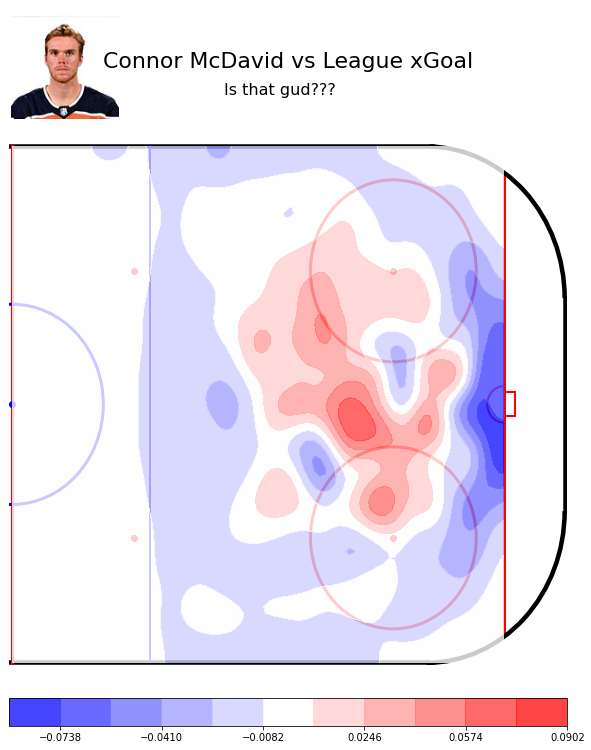

In [789]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Connor McDavid'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

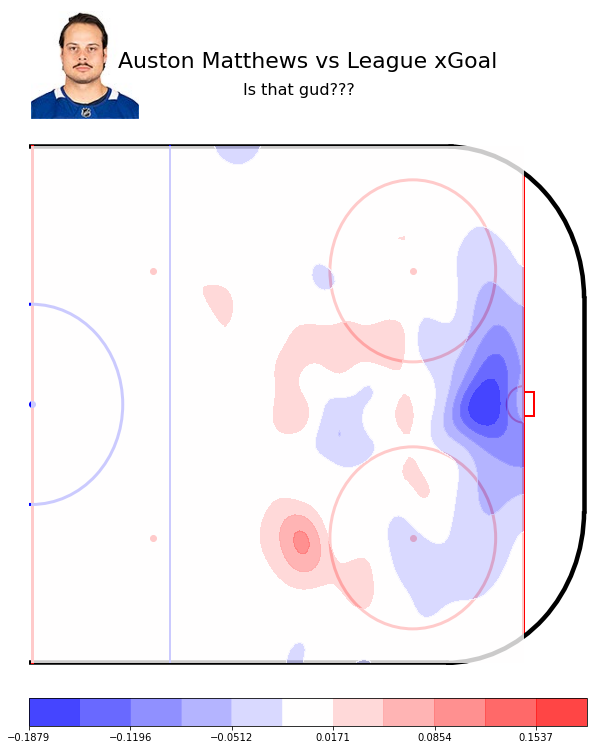

In [788]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Auston Matthews'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

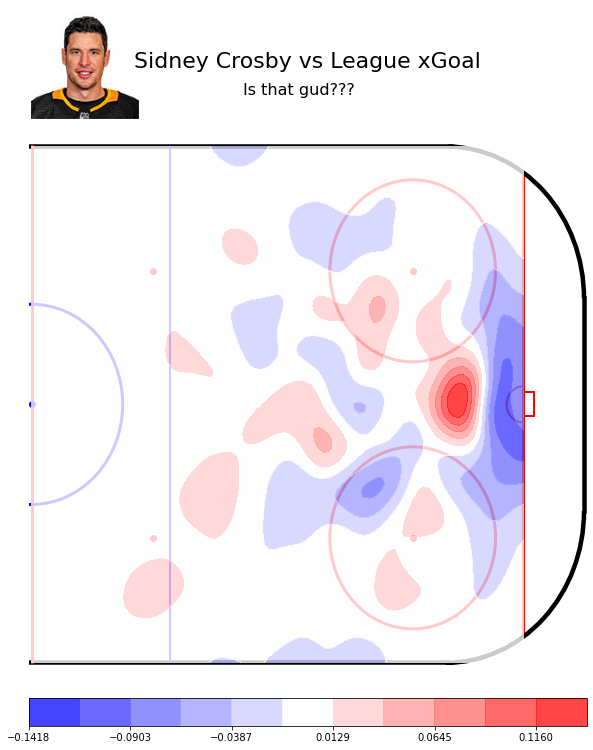

In [787]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Sidney Crosby'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

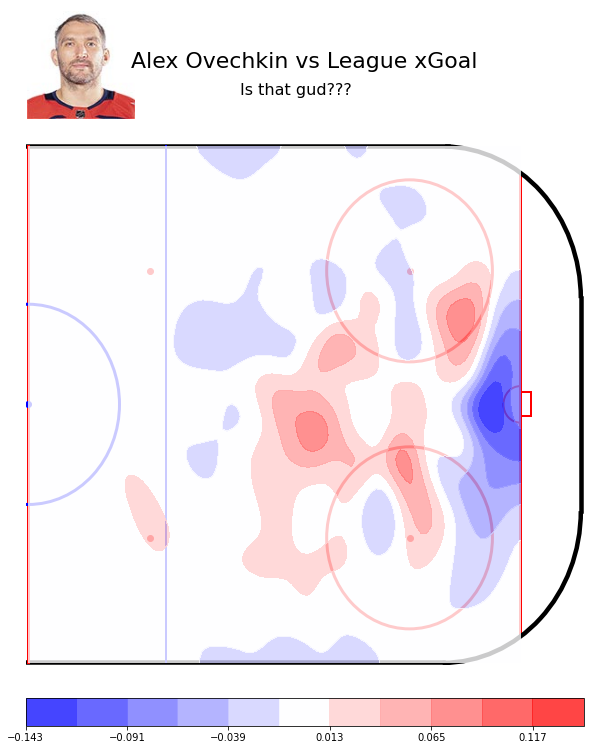

In [786]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Alex Ovechkin'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

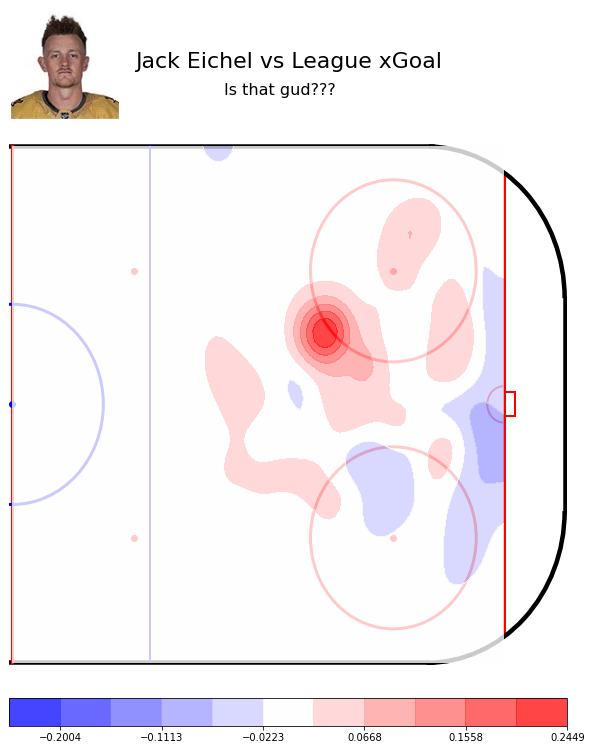

In [785]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Jack Eichel'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

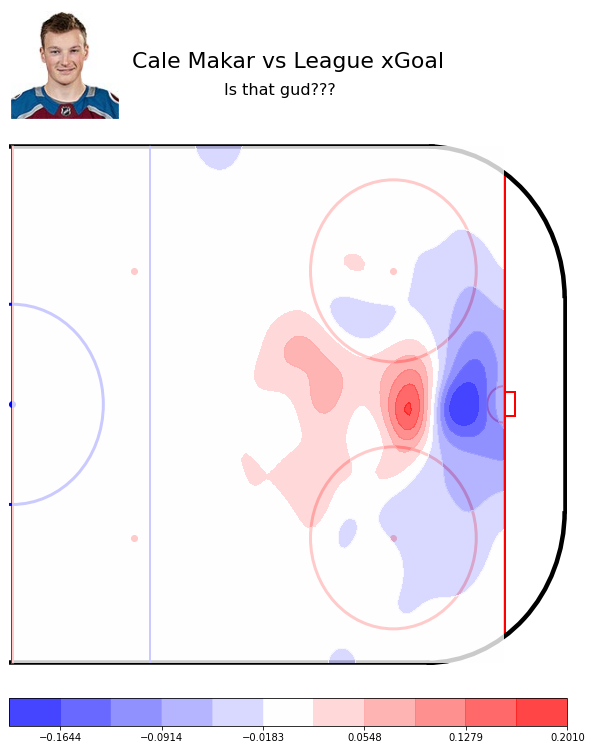

In [784]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Cale Makar'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()

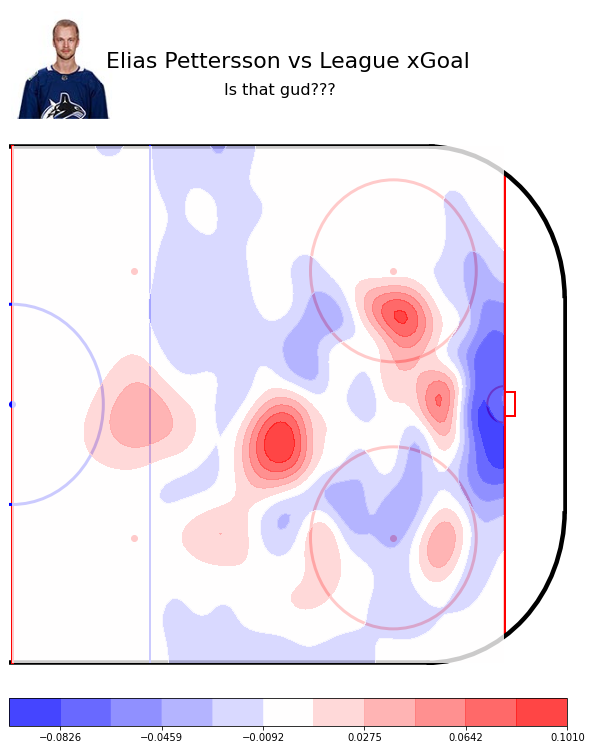

In [793]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

# Set vars
player_name = 'Elias Pettersson'
image_path = '.output/img.png'

# Create data
all_xg = create_xg_array(ev_data, is_smooth = True)
player_xg = create_xg_array(ev_data[ev_data['player_name'] == player_name], is_smooth = True)
new_diff = player_xg - all_xg

# Assuming you have an image file at '.output/mcd.png'
filter = ev_data[ev_data['player_name'] == player_name]
headshots_df = get_player_headshots("https://cms.nhl.bamgrid.com/images/headshots/current/60x60/{player_id}@2x.jpg", np.unique(filter[['player_id']]))
headshots_df['img'].iloc[0].save(image_path, format = 'PNG')

# Load the image
mcd_image = Image.open(image_path)

# Create the OffsetImage object
mcd_imagebox = OffsetImage(mcd_image, zoom=0.9)

# Calculate the position for the image (adjust as needed)
image_x = 0.1  # Adjust the x-coordinate
image_y = 1.15   # Adjust the y-coordinate

data_min = new_diff.min()
data_max = new_diff.max()
mid_val = new_diff.mean()

if abs(data_min) > data_max:
    data_max = data_min * -1
elif data_max > abs(data_min):
    data_min = data_max * -1

fig, ax = plt.subplots(1, 1, figsize=(10, 12), facecolor='w', edgecolor='k')

# Add the image to the plot
ab = AnnotationBbox(mcd_imagebox, (image_x, image_y), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

create_rink(ax, plot_half=True, board_radius=25, alpha=1.0)

ax = ax.contourf(
    new_diff, alpha=0.8, cmap='bwr',
    extent=(0, 89, -42.5, 42.5),
    levels=np.linspace(data_min, data_max, 12),
    vmin=data_min,
    vmax=data_max,
    # norm = mpl.colors.Normalize(vmin = -0.05, vmax = 0.05),
)

# Set the title and subtitle with manual padding
title_text = f'{player_name} vs League xGoal'
subtitle_text = 'Is that gud???'

plt.title(title_text, fontsize=22, pad=75)  # Adjust the pad value for title padding
plt.suptitle(subtitle_text, y=.95, fontsize=16)

fig.colorbar(ax, orientation="horizontal", pad=0.05)
plt.axis('off')
plt.show()